In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import numpy as np
print(cv2.__version__)

4.1.1


### Open Video and show FPS

In [2]:
video = 'record-20190122-211815'
vidcap = cv2.VideoCapture(video + '.mp4')

fps = vidcap.get(cv2.CAP_PROP_FPS)
print('FPS = %.3f' % fps)

FPS = 36.868


### Read and display the first frame

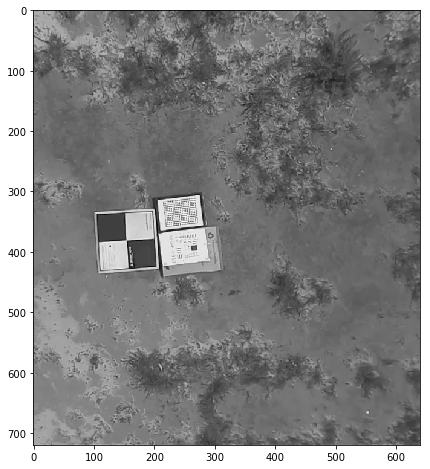

In [3]:
success, image = vidcap.read()
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#crop the right half of the frame
cropped = img_gray[:,int(-1280/2):]
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(cropped,cmap='gray')

### Identify the template to match in each frame - in this instance we will use the calibration targets

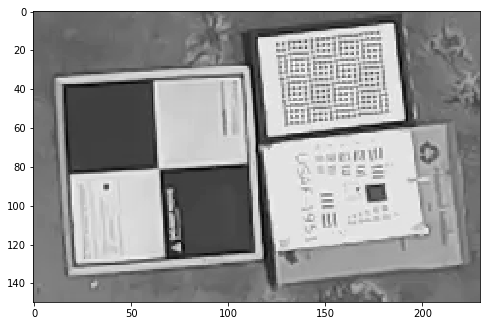

In [4]:
template = cropped[300:450,90:320]
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(template,cmap='gray')

### Search the image for the template using cross correlation

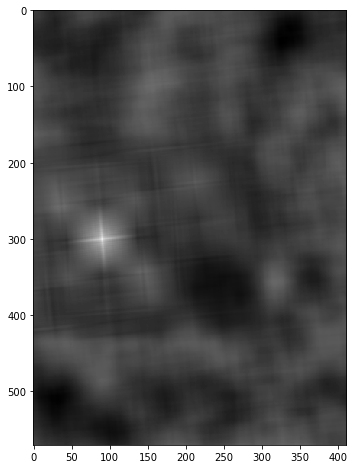

In [5]:
ccoeff = cv2.matchTemplate(cropped, template, method=cv2.TM_CCOEFF_NORMED)
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(ccoeff,cmap='gray')
y,x=np.unravel_index(np.argmax(ccoeff),ccoeff.shape)
y0 = y + template.shape[0]/2
x0 = x + template.shape[1]/2

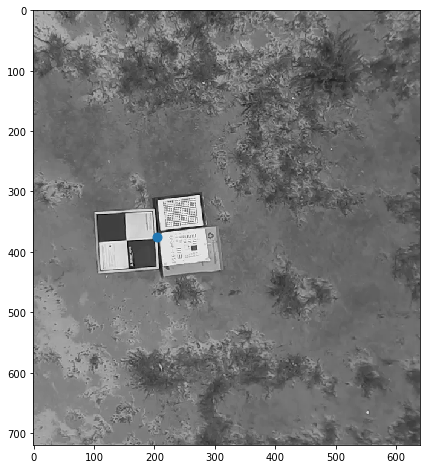

In [6]:
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(cropped,cmap='gray')
ax.scatter(x0,y0,80,marker='o')

### Now we will search for this template in each frame

In [7]:
def locate_template(frame,template):
    img_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #crop the right half of the frame
    cropped = img_gray[:,int(-1280/2):]
    ccoeff = cv2.matchTemplate(cropped, template, method=cv2.TM_CCOEFF_NORMED)
    y,x=np.unravel_index(np.argmax(ccoeff),ccoeff.shape)
    y = y + template.shape[0]/2
    x = x + template.shape[1]/2
    return x, y

In [15]:
vidcap = cv2.VideoCapture(video + '.mp4')
count = 0
success = True
results = []
success,frame = vidcap.read()
while success:
    
    x, y = locate_template(frame,template)
    dx = x - x0
    dy = y - y0
    
    results.append((dx,dy))
    
    if count % 100 == 0:
        print('Processed frame: ', count)
    count += 1
    success,frame = vidcap.read()

Processed frame:  0
Processed frame:  100
Processed frame:  200
Processed frame:  300
Processed frame:  400
Processed frame:  500
Processed frame:  600
Processed frame:  700
Processed frame:  800
Processed frame:  900
Processed frame:  1000


In [17]:
resultsA=np.array(results)
resultsA=resultsA-np.min(resultsA,axis=0)

Text(0, 0.5, 'y-offset (px)')

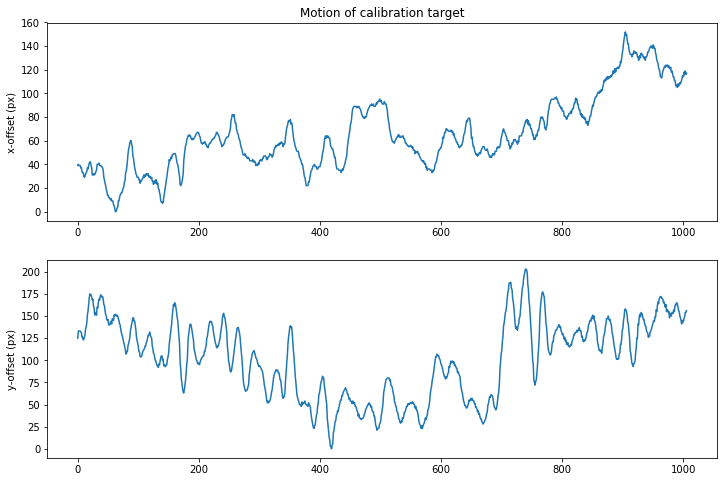

In [18]:
fig,axs = plt.subplots(2,1,figsize=[12,8])
ax = axs[0]
ax.set_title('Motion of calibration target')
ax.plot(resultsA[:,0])
ax.set_ylabel('x-offset (px)')

ax = axs[1]
ax.plot(resultsA[:,1])
ax.set_ylabel('y-offset (px)')

In [20]:
max_shift=np.max(resultsA,axis=0)
print(max_shift)

[152. 203.]


In [21]:
w = int(cropped.shape[0] + max_shift[0])
h = int(cropped.shape[1] + max_shift[1])+1

In [27]:
out_folder = 'shifted'
if os.path.isdir(out_folder):
    shutil.rmtree(out_folder)
os.mkdir(out_folder)

vidcap = cv2.VideoCapture(video + '.mp4')
count = 0
success = True
success,frame = vidcap.read()
while success:
    
    img_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #crop the right half of the frame
    cropped = img_gray[:,int(-1280/2):]
    
    dx = -resultsA[count,0]+max_shift[0]
    dy = -resultsA[count,1]+max_shift[1]
    transform = np.array([[1,0,dx],[0,1,dy]],dtype=np.float32)
    
    output = cv2.warpAffine(cropped,transform,(w,h))
    
    cv2.imwrite(out_folder + "/frame%07.0f.png" % count, output)     # save frame as PNG file
    
    if count % 100 == 0:
        print('Processed frame: ', count)
    count += 1
    success,frame = vidcap.read()

vidcap.release()

Processed frame:  0
Processed frame:  100
Processed frame:  200
Processed frame:  300
Processed frame:  400
Processed frame:  500
Processed frame:  600
Processed frame:  700
Processed frame:  800
Processed frame:  900
Processed frame:  1000


In [29]:
!cd shifted && ffmpeg -r 36.8677777 -i frame%07d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p ../shifted.mp4 && cd .. 

ffmpeg version 4.1.3 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1556785800657/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 22.100 / 56. 22.100
  libavcodec     58. 35.100 / 58. 35.100
  libavformat    58. 20.100 / 58. 20.100
  libavdevice    58.  5.100 / 58.  5.100
  libavfilter     7. 40.101 /  7. 40.101
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  3.100 /  5.  3.100
  libswresample   3.  3.100 /  3.  3.100
  libpostproc    55.  3.100 / 55.  3.100
Input #0, image2, from 'frame%07d.png':
  Duration: 00:00:40.24, start: 0.00